<a href="https://colab.research.google.com/github/aashrithresearch/endometrial-cancer/blob/main/eh%20classification/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q datasets transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset

dataset = load_dataset('/content/drive/MyDrive/eh classification')

Resolving data files:   0%|          | 0/2131 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [5]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1917
})

In [6]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Endometrial Hyperplasia', 'Normal Endometrium'], id=None)}

In [7]:
train_ds[0]['label']

0

In [8]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Endometrial Hyperplasia', 1: 'Normal Endometrium'}

In [9]:
id2label[train_ds[0]['label']]

'Endometrial Hyperplasia'

In [10]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [11]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [12]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [13]:
train_ds[:2]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>],
 'label': [0, 1],
 'pixel_values': [tensor([[[ 0.2784,  0.2706,  0.3020,  ...,  0.2941,  0.1843,  0.0275],
           [ 0.3098,  0.2784,  0.3176,  ...,  0.3333,  0.3098,  0.1686],
           [ 0.3255,  0.2784,  0.3255,  ...,  0.4039,  0.2784,  0.1059],
           ...,
           [ 0.0275,  0.0275,  0.3176,  ...,  0.5294,  0.5216,  0.5686],
           [ 0.3333,  0.3569,  0.6078,  ...,  0.4824,  0.4980,  0.5922],
           [ 0.6000,  0.6471,  0.7020,  ...,  0.4196,  0.4667,  0.6157]],
  
          [[ 0.0510,  0.0353,  0.0353,  ...,  0.0745, -0.0196, -0.1608],
           [ 0.0118, -0.0275,  0.0039,  ..., -0.0275, -0.0196, -0.0902],
           [-0.0588, -0.0980, -0.0588,  ..., -0.0353, -0.0980, -0.1686],
           ...,
           [ 0.0353,  0.0275,  0.3490,  ...,  0.7098,  0.7020,  0.7020],
           [ 0.3961,  0.3961,  0.6314,  ...,  0.6157,  0

In [14]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [16]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-et",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=25,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels), precision_recall_fscore_support=precision_recall_fscore_support(predictions, labels, average='macro'))

In [19]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-19-0bb229cc289f>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision Recall Fscore Support
1,No log,0.397388,0.831776,"(0.8243255196815569, 0.8343821249430005, 0.8274193548387097, None)"
2,No log,0.362355,0.845794,"(0.8379920389208315, 0.849908424908425, 0.8415561688093155, None)"
3,0.368000,0.270619,0.892523,"(0.8885006634232641, 0.8935483870967742, 0.8905127349571794, None)"
4,0.368000,0.265230,0.911215,"(0.9063688633348076, 0.9143217893217893, 0.9093119214899075, None)"
5,0.368000,0.215163,0.925234,"(0.9285272003538257, 0.923729554797516, 0.9248133509003074, None)"
6,0.234500,0.215065,0.911215,"(0.9106147722246793, 0.9097810734463276, 0.910177391919058, None)"
7,0.234500,0.209427,0.939252,"(0.9368863334807607, 0.94003920171062, 0.9382696873543834, None)"
8,0.182600,0.341105,0.883178,"(0.8716054842989827, 0.9005530129672006, 0.8782624524996018, None)"
9,0.182600,0.234474,0.920561,"(0.9158337019018135, 0.9239718614718615, 0.9188580350172856, None)"
10,0.182600,0.248455,0.934579,"(0.9358690844758957, 0.9328063241106719, 0.934002995858666, None)"


Trainer is attempting to log a value of "(0.8243255196815569, 0.8343821249430005, 0.8274193548387097, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.8379920389208315, 0.849908424908425, 0.8415561688093155, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.8885006634232641, 0.8935483870967742, 0.8905127349571794, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.9063688633348076, 0.9143217893217893, 0.9093119214899075, None)" of type <class 'tuple'> f

Epoch,Training Loss,Validation Loss,Accuracy,Precision Recall Fscore Support
1,No log,0.397388,0.831776,"(0.8243255196815569, 0.8343821249430005, 0.8274193548387097, None)"
2,No log,0.362355,0.845794,"(0.8379920389208315, 0.849908424908425, 0.8415561688093155, None)"
3,0.368000,0.270619,0.892523,"(0.8885006634232641, 0.8935483870967742, 0.8905127349571794, None)"
4,0.368000,0.265230,0.911215,"(0.9063688633348076, 0.9143217893217893, 0.9093119214899075, None)"
5,0.368000,0.215163,0.925234,"(0.9285272003538257, 0.923729554797516, 0.9248133509003074, None)"
6,0.234500,0.215065,0.911215,"(0.9106147722246793, 0.9097810734463276, 0.910177391919058, None)"
7,0.234500,0.209427,0.939252,"(0.9368863334807607, 0.94003920171062, 0.9382696873543834, None)"
8,0.182600,0.341105,0.883178,"(0.8716054842989827, 0.9005530129672006, 0.8782624524996018, None)"
9,0.182600,0.234474,0.920561,"(0.9158337019018135, 0.9239718614718615, 0.9188580350172856, None)"
10,0.182600,0.248455,0.934579,"(0.9358690844758957, 0.9328063241106719, 0.934002995858666, None)"


Trainer is attempting to log a value of "(0.9358248562582928, 0.9414874551971326, 0.9381158936714493, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=4800, training_loss=0.14103099584579468, metrics={'train_runtime': 4912.0899, 'train_samples_per_second': 9.757, 'train_steps_per_second': 0.977, 'total_flos': 3.7138036022793216e+18, 'train_loss': 0.14103099584579468, 'epoch': 25.0})

In [21]:
trainer.evaluate()

Trainer is attempting to log a value of "(0.9442724458204335, 0.9425500044056745, 0.9433262711864407, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2349676638841629,
 'eval_accuracy': 0.9439252336448598,
 'eval_precision_recall_fscore_support': (0.9442724458204335,
  0.9425500044056745,
  0.9433262711864407,
  None),
 'eval_runtime': 9.3856,
 'eval_samples_per_second': 22.801,
 'eval_steps_per_second': 5.754,
 'epoch': 25.0}

In [22]:
from sklearn.metrics import classification_report

preds = trainer.predict(val_ds)
preds.metrics

{'test_loss': 0.2349676638841629,
 'test_accuracy': 0.9439252336448598,
 'test_precision_recall_fscore_support': (0.9442724458204335,
  0.9425500044056745,
  0.9433262711864407,
  None),
 'test_runtime': 6.2462,
 'test_samples_per_second': 34.261,
 'test_steps_per_second': 8.645}

In [23]:
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        95
           1       0.96      0.94      0.95       119

    accuracy                           0.94       214
   macro avg       0.94      0.94      0.94       214
weighted avg       0.94      0.94      0.94       214



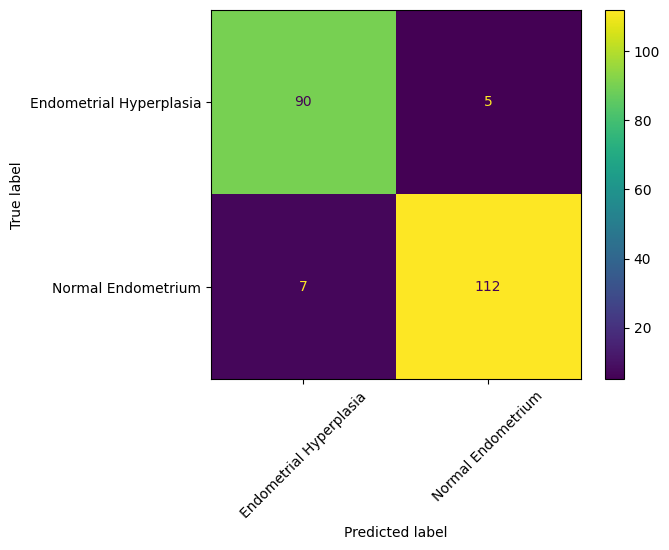

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)